# Setup Jupyter Notebook

In [2]:
from pathlib import Path
import sys

notebook_directory_parent = Path.cwd().resolve().parent.parent
if str(notebook_directory_parent) not in sys.path:
    sys.path.append(str(notebook_directory_parent))

In [3]:
print(notebook_directory_parent)

/home/topolo/PropD/Propulsion/T1000


In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import control
import control.matlab as controlmatlab

cf. [Discrete control #1: Introduction and overview, Aug. 11, 2017](https://youtu.be/14cMhrp5wlk), [Brian Douglas](https://www.youtube.com/channel/UCq0imsn84ShAe9PBOFnoIrg)

In [2]:
G = control.tf([1,], [0.2, 1])
print(G)


    1
---------
0.2 s + 1



Text(0.5, 1.0, 'Step Response')

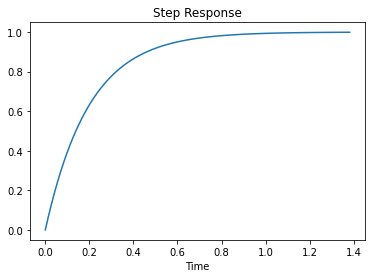

In [14]:
t, y = control.step_response(G)
plt.plot(t, y)
plt.xlabel('Time')
plt.title('Step Response')

In [7]:
unit_step = control.tf([1,], [1, 0])
print(unit_step)


1
-
s




     1
-----------
0.2 s^2 + s



Text(0.5, 1.0, 'Ramp Response')

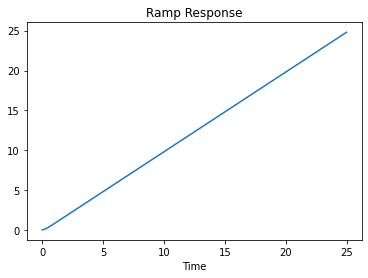

In [15]:
print(G * unit_step)
t, y = control.step_response(G * unit_step)
plt.plot(t, y)
plt.xlabel('Time')
plt.title('Ramp Response')

This is hard to see, let's compare to just a ramp

Text(0.5, 1.0, 'Ramp Response Difference')

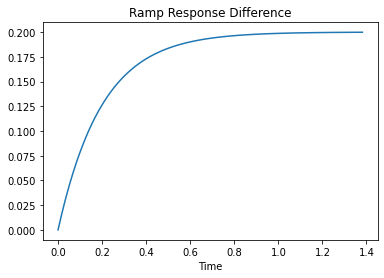

In [16]:
t_diff, y_diff = control.step_response(unit_step - G * unit_step)
plt.plot(t_diff, y_diff)
plt.xlabel('Time')
plt.title('Ramp Response Difference')

Steady State Error is 0.2 (20%), greater than say requirement of Steady State Error being < 2% for ramp input.

Since it's first-order, open loop, it has infinite phase margin, no amount of phase lag will make system unstable.

Create the controller transfer function.

In [17]:
C = control.tf([500, 50], [100, 1, 0])
print(C)


500 s + 50
-----------
100 s^2 + s



Create the feedback system and find the closed loop transfer function.

In [20]:
CL = control.feedback(C*G, 1)
print(CL)


          500 s + 50
-------------------------------
20 s^3 + 100.2 s^2 + 501 s + 50



Check the ramp steady state error like we did before

Text(0.5, 1.0, 'ramp steady state error')

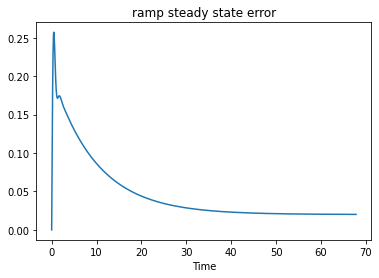

In [21]:
t, y = control.step_response(unit_step - CL * unit_step)
plt.plot(t, y)
plt.xlabel('Time')
plt.title('ramp steady state error')

There's a jump in error in the beginning, and then goes to 2 percent error.

To find phase margin we look at Bode plot of open loop system.

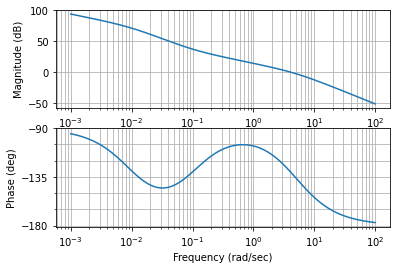

In [22]:
mag, phase, omega = control.matlab.bode(C*G)

In [25]:
# wpc = crossover frequency, wgc = gain crossover frequency (where gain crosses 1)
gain_margin, phase_margin, wpc, wgc = control.margin(C*G)
print(gain_margin)
print(phase_margin) # 50.5 phase margin, beating a 48 degree phase margin
print(wpc)
print(wgc)

inf
50.50959723786886
nan
3.9316674763909094


We can convert to a discrete transfer function in the z domain using c2d()   
Default conversion method is Zero Order Hold (ZOH)

In [27]:
# c2d returns sysd - Discrete time system, with sampling rate Ts
Cz = control.matlab.c2d(C, 0.1) # default 'zoh'
print(Cz)


  0.5022 z - 0.4973
---------------------
z^2 - 1.999 z + 0.999

dt = 0.1



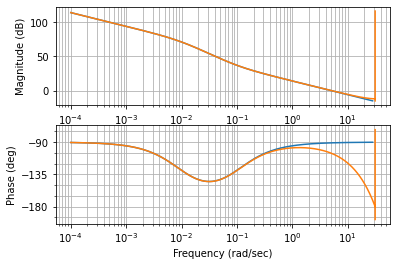

In [28]:
mag, phase, omega = control.matlab.bode(C, Cz)

In [31]:
gain_margin, phase_margin, wpc, wgc = control.margin(Cz)
print(gain_margin)
print(phase_margin) 
print(wpc)
print(wgc)

inf
74.52149451559609
nan
5.05456707098255


cf. [Discrete control #2: Discretize! Going from continuous to discrete domain](https://youtu.be/rL_1oWrOplk) [Brian Douglas](https://www.youtube.com/channel/UCq0imsn84ShAe9PBOFnoIrg)

In [33]:
G_s = control.tf([1,], [1, 3, 2])
print(G_s)
Z_g_k = control.matlab.c2d(G_s, 1., 'zoh')
print(Z_g_k)


      1
-------------
s^2 + 3 s + 2


   0.1998 z + 0.0735
------------------------
z^2 - 0.5032 z + 0.04979

dt = 1.0



In [34]:
np.exp(-0.1)

0.9048374180359595

In [35]:
G = control.tf([1], [1, 1])
print(G)
Ts = 0.1 # seconds


  1
-----
s + 1



Discretization is done with the function c2d

In [36]:
help(control.matlab.c2d)

Help on function c2d in module control.dtime:

c2d(sysc, Ts, method='zoh', prewarp_frequency=None)
    Convert a continuous time system to discrete time by sampling
    
    Parameters
    ----------
    sysc : LTI (StateSpace or TransferFunction)
        Continuous time system to be converted
    Ts : real > 0
        Sampling period
    method : string
        Method to use for conversion, e.g. 'bilinear', 'zoh' (default)
    
    prewarp_frequency : real within [0, infinity)
        The frequency [rad/s] at which to match with the input continuous-
        time system's magnitude and phase
    
    Returns
    -------
    sysd : linsys
        Discrete time system, with sampling rate Ts
    
    Notes
    -----
    See :meth:`StateSpace.sample` or :meth:`TransferFunction.sample`` for
    further details.
    
    Examples
    --------
    >>> sysc = TransferFunction([1], [1, 2, 1])
    >>> sysd = sample_system(sysc, 1, method='bilinear')



In [40]:
Gz = control.matlab.c2d(G, Ts, 'zoh')
print(Gz)
Gf = control.matlab.c2d(G, Ts, 'foh')
print(Gf)
Gi = control.matlab.c2d(G, Ts, 'impulse')
print(Gi)
Gt = control.matlab.c2d(G, Ts, 'tustin')
print(Gt)
Gm = control.matlab.c2d(G, Ts, 'matched')
print(Gm)
Gb = control.matlab.c2d(G, Ts, 'bilinear')
print(Gb)


 0.09516
----------
z - 0.9048

dt = 0.1


0.04837 z + 0.04679
-------------------
    z - 0.9048

dt = 0.1


  0.1 z
----------
z - 0.9048

dt = 0.1


0.04762 z + 0.04762
-------------------
    z - 0.9048

dt = 0.1


 0.09516
----------
z - 0.9048

dt = 0.1


0.04762 z + 0.04762
-------------------
    z - 0.9048

dt = 0.1



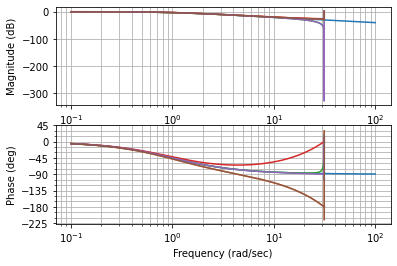

In [41]:
mag, phase, omega = control.matlab.bode(G, Gz, Gf, Gi, Gt, Gm)
plt.legend()

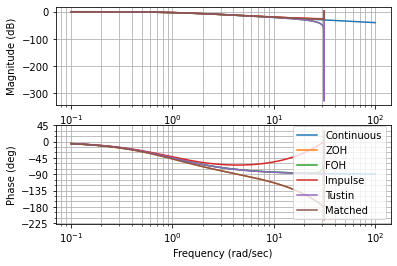

In [43]:
mag, phase, omega = control.bode_plot([G, Gz, Gf, Gi, Gt, Gm])
plt.gca().legend(('Continuous', 'ZOH', 'FOH', 'Impulse', 'Tustin', 'Matched'))

In [45]:
y, T = control.matlab.step(G)
yz, Tz = control.matlab.step(Gz)
yf, Tf = control.matlab.step(Gf)
yi, Ti = control.matlab.step(Gi)
yt, Tt = control.matlab.step(Gt)
ym, Tm = control.matlab.step(Gm)

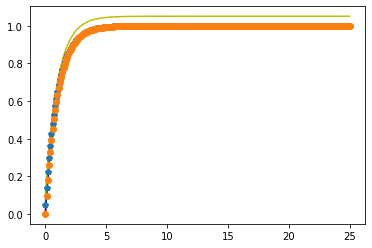

In [48]:
plt.plot(T, y, 'r')
plt.plot(Tz, yz, 'b')
plt.plot(Tf, yf, 'g')
plt.plot(Ti, yi, 'y')
plt.plot(Tt, yt, 'p')
plt.plot(Tm, ym, 'o')
plt.show()

In [49]:
print(Gi)


  0.1 z
----------
z - 0.9048

dt = 0.1



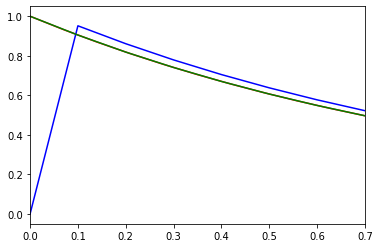

In [52]:
T, y = control.impulse_response(G)
Ti, yi = control.impulse_response(Gi)
Tz, yz = control.impulse_response(Gz)
plt.plot(T, y, 'r')
plt.plot(Tz, yz, 'b')
plt.plot(Ti, yi, 'g')
plt.xlim([0.0, 0.7])
plt.show()